In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
pd.set_option('display.max_columns', None)
import os
print(os.listdir("../input"))

['train.csv', 'sample_submission.csv', 'test.csv']


**EDA**

In [2]:
train = pd.read_csv('../input/train.csv',index_col = 'Id')
test = pd.read_csv('../input/test.csv',index_col = 'Id')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10806 entries, 1 to 10806
Data columns (total 21 columns):
House_Id         10806 non-null int64
date             10806 non-null object
price            10806 non-null float64
bedrooms         10806 non-null int64
bathrooms        10806 non-null float64
sqft_living      10806 non-null int64
sqft_lot         10806 non-null int64
floors           10806 non-null float64
waterfront       10806 non-null int64
view             10806 non-null int64
condition        10806 non-null int64
grade            10806 non-null int64
sqft_above       10806 non-null int64
sqft_basement    10806 non-null int64
yr_built         10806 non-null int64
yr_renovated     10806 non-null int64
zipcode          10806 non-null int64
lat              10806 non-null float64
long             10806 non-null float64
sqft_living15    10806 non-null int64
sqft_lot15       10806 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 1.8+ MB


In [4]:
train.head()

,House_Id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
Id,,,,,,,,,,,,,,,,,,,,,
1,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
2,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
3,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
4,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
5,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


**Log-transformation dari price**

In [5]:
train.price= np.log1p(train["price"])#mengubah skala price untuk mempermudah modelling

**UNIVARIATE ANALYSIS**

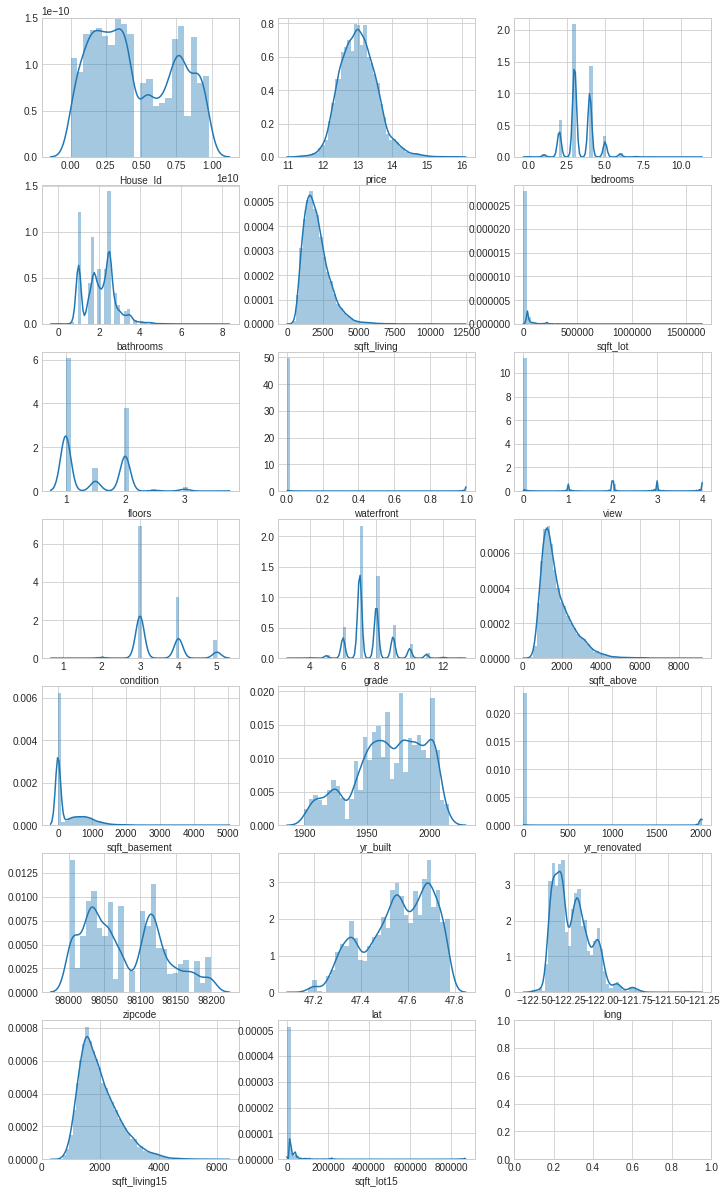

In [6]:
numerical_cols = [cname for cname in train.columns if 
                train[cname].dtype in ['int64', 'float64']]
plt.style.use('seaborn-whitegrid')
fig, axarr = plt.subplots(7, 3, figsize=(12, 21))
for i in range(len(numerical_cols)):
    sns.distplot(train[~train[numerical_cols[i]].isnull()][numerical_cols[i]],ax=axarr[int(i/3)][i%3])


**BIVARIATE ANALYSIS**

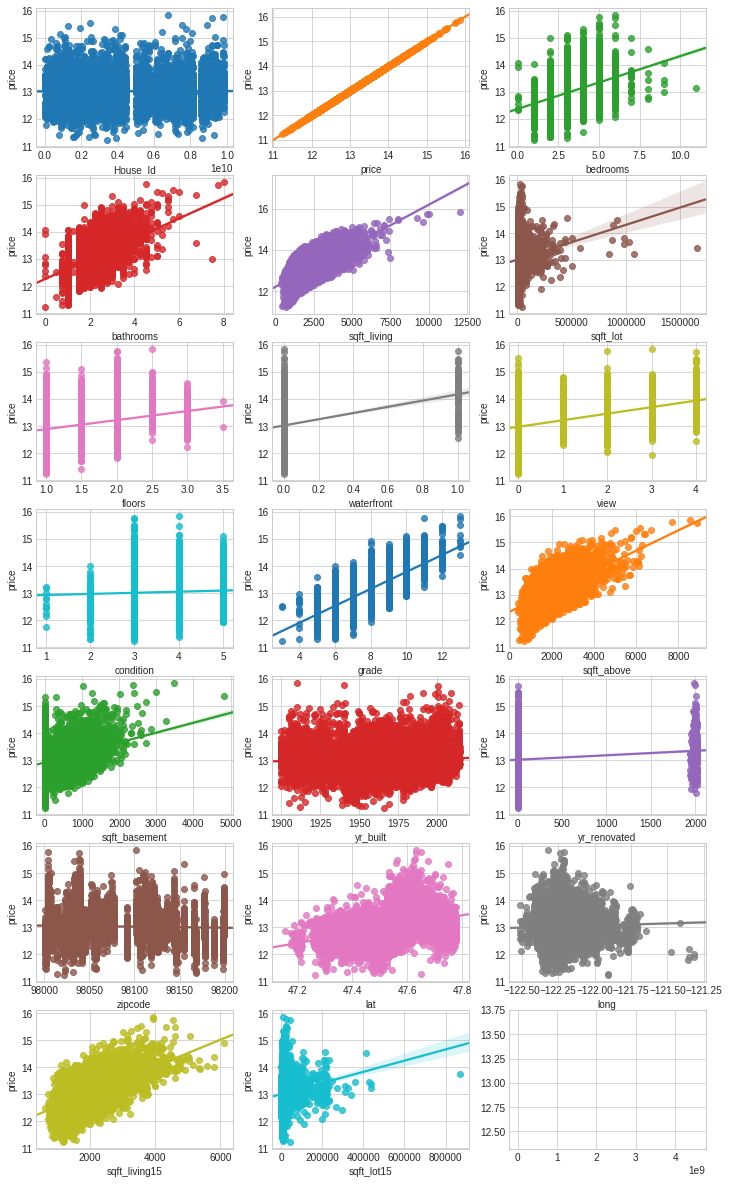

In [7]:
fig, axarr = plt.subplots(7, 3, figsize=(12, 21))
for i in range(len(numerical_cols)):
    sns.regplot(x=numerical_cols[i],y='price',data=train,ax=axarr[int(i/3)][i%3])


**OUTLIER**

In [8]:
train = train[~((train.bathrooms>6)& (train.price<14))]

**HEATMAP**

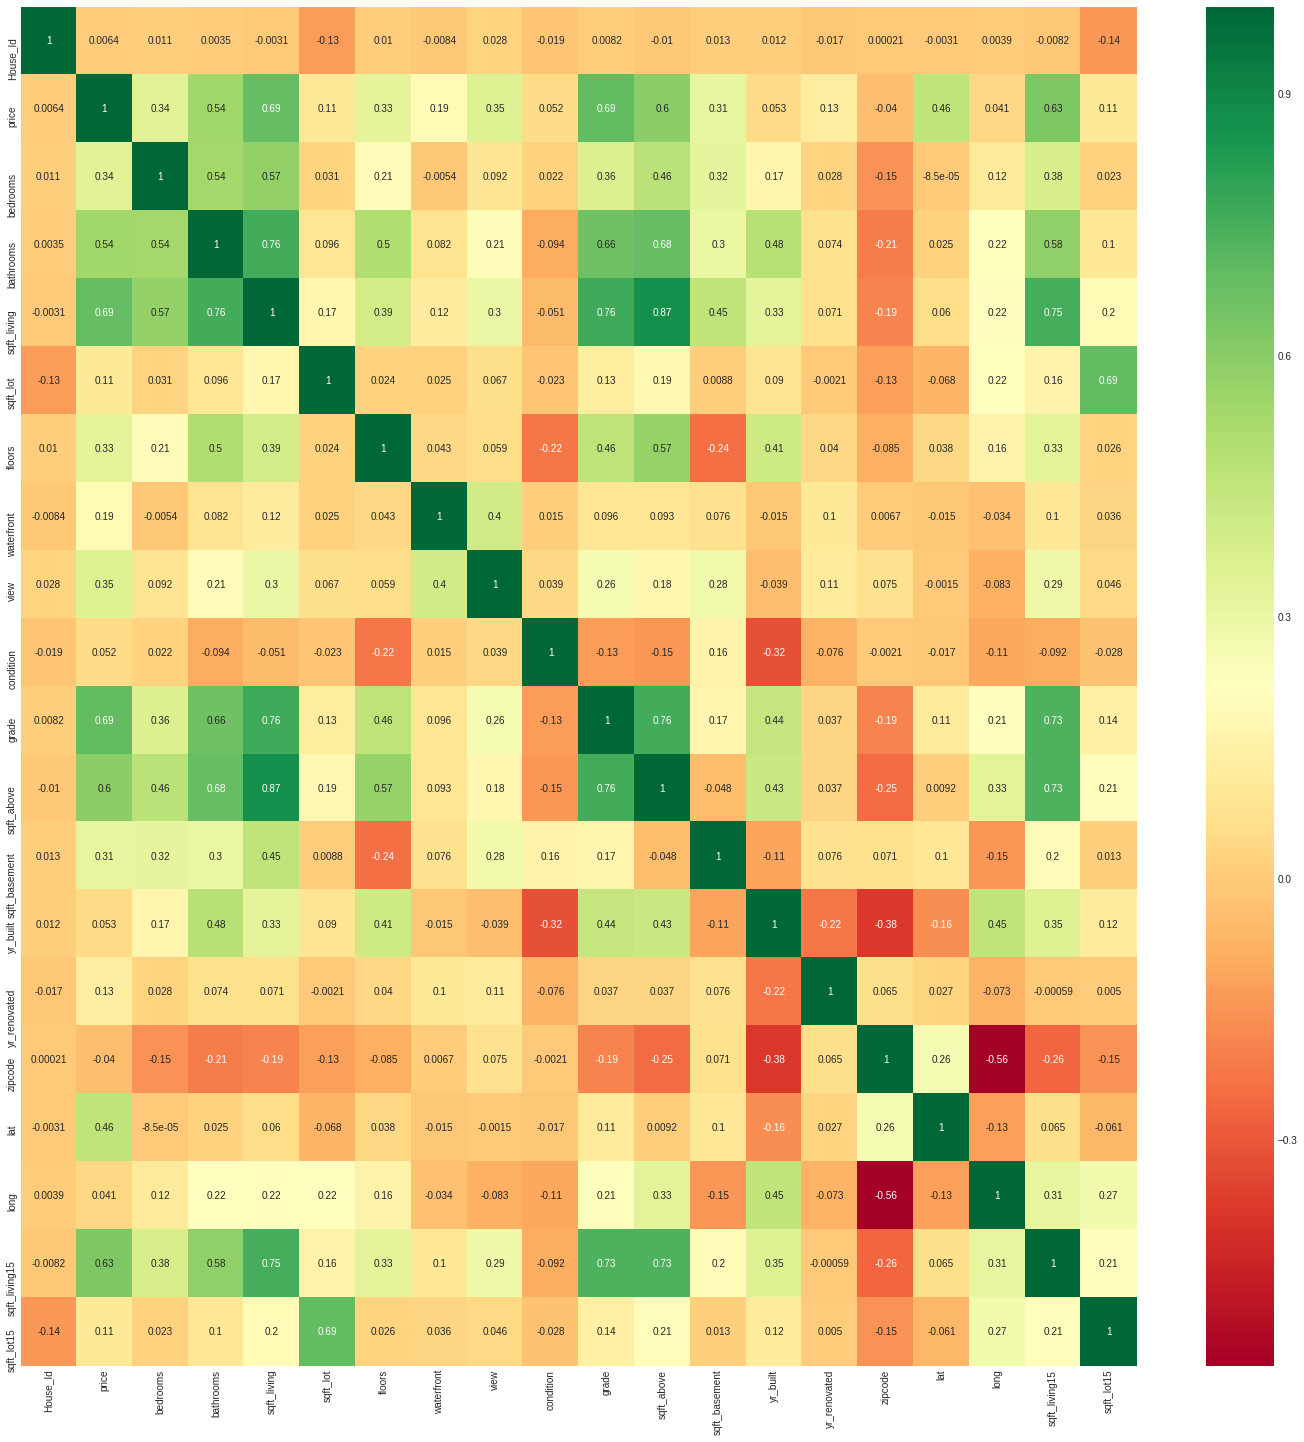

In [9]:
train_corr = train.copy()
corrmat = train_corr.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,25))
#plot heat map
g=sns.heatmap(train_corr[top_corr_features].corr(),annot=True,cmap="RdYlGn")
g

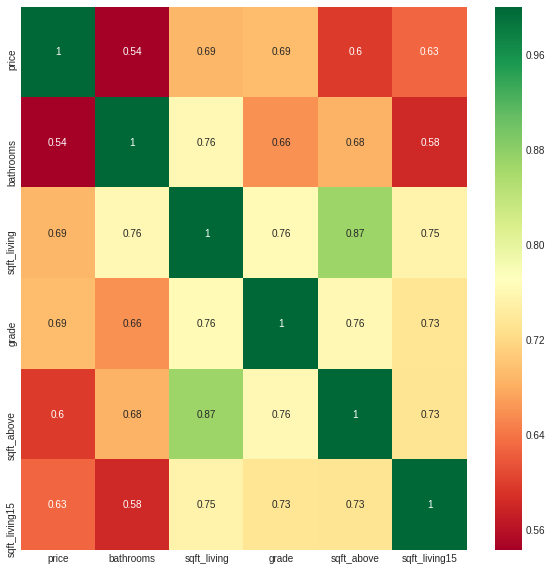

In [10]:
corrmat = train_corr.corr()
top_corr_features = corrmat.index[abs(corrmat["price"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(train_corr[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [11]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.price.values
all_data = pd.concat((train, test))
all_data.drop(['price'], axis=1, inplace=True)
all_data.shape
#train dan test disatukan sementara untuk diolah lebih lanjut

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


(21611, 20)

**MISSING DATA**

In [12]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio


**FEATURE ENGINNERING**

In [13]:
#mengubah kolom zipcode menjadi categorical
all_data['zipcode'] = all_data['zipcode'].apply(str)

In [14]:
#membuat kolom baru dari kolom date
all_data['YrSold'] =all_data['date'].apply(lambda s:int(s[:4]))
all_data['MonthSold'] =all_data['date'].apply(lambda s:(s[4:6]))
all_data['DaySold'] =all_data['date'].apply(lambda s:int(s[6:8]))
all_data.drop(['date'], axis=1, inplace=True)
#membuat kolom jumlah ruangan
all_data['rooms'] = all_data['bedrooms']+all_data['bathrooms']
all_data.head()

,House_Id,bathrooms,bedrooms,condition,floors,grade,lat,long,sqft_above,sqft_basement,sqft_living,sqft_living15,sqft_lot,sqft_lot15,view,waterfront,yr_built,yr_renovated,zipcode,YrSold,MonthSold,DaySold,rooms
Id,,,,,,,,,,,,,,,,,,,,,,,
1,7129300520,1.00,3,3,1.0,7,47.5112,-122.257,1180,0,1180,1340,5650,5650,0,0,1955,0,98178,2014,10,13,4.00
2,6414100192,2.25,3,3,2.0,7,47.7210,-122.319,2170,400,2570,1690,7242,7639,0,0,1951,1991,98125,2014,12,9,5.25
3,5631500400,1.00,2,3,1.0,6,47.7379,-122.233,770,0,770,2720,10000,8062,0,0,1933,0,98028,2015,02,25,3.00
4,2487200875,3.00,4,5,1.0,7,47.5208,-122.393,1050,910,1960,1360,5000,5000,0,0,1965,0,98136,2014,12,9,7.00
5,1954400510,2.00,3,3,1.0,8,47.6168,-122.045,1680,0,1680,1800,8080,7503,0,0,1987,0,98074,2015,02,18,5.00


**Transformasi Feature**: fitur dibikin terdistribusi normal

In [15]:
from scipy.stats import skew
numerical_cols = [cname for cname in all_data.columns if 
                all_data[cname].dtype in ['int64', 'float64']]
skewness = all_data[numerical_cols].apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.9]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = list(skewness.index)
all_data[skewed_features] = np.log1p(all_data[skewed_features])

11 skewed numerical features to log transform


**Convert kolom categorical ke numerical **

In [16]:
Dummies_all_data = pd.get_dummies(all_data)

In [17]:
#data dipisah kembali jadi train sama test
X_train = Dummies_all_data[:ntrain]
X_test = Dummies_all_data[ntrain:]

**Modelling**

In [18]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor

n_folds=5
def rmsle_cv(model):
    rmsle= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    print("\nscore rmsle: {:.4f} ({:.4f})\n".format(rmsle.mean(), rmsle.std()))
    return(rmsle)


In [19]:
model_xgb = XGBRegressor(colsample_bytree=1, gamma=0.0468, 
                             learning_rate=0.053, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                              subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score_xgb = rmsle_cv(model_xgb)
#0.1878 (0.0041)


score rmsle: 0.1631 (0.0022)



In [20]:
model_LGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score_LGB = rmsle_cv(model_LGB)


score rmsle: 0.1708 (0.0032)



In [21]:
model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score_GBoost = rmsle_cv(model_GBoost)


score rmsle: 0.1637 (0.0033)



In [22]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score_ENet = rmsle_cv(ENet)


score rmsle: 0.1850 (0.0050)



In [23]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score_lasso = rmsle_cv(lasso)


score rmsle: 0.1858 (0.0050)



**Averaging Model**

In [24]:
model_GBoost.fit(X_train,y_train)
model_xgb.fit(X_train,y_train)
model_LGB.fit(X_train,y_train)
lasso.fit(X_train,y_train)
ENet.fit(X_train,y_train)
lasso.fit(X_train,y_train)
preds_test = np.expm1( model_xgb.predict(X_test)*0.50 + (
    model_LGB.predict(X_test)*0.10+ model_GBoost.predict(X_test)*0.30) + (
lasso.predict(X_test)*0.05+ENet.predict(X_test)*0.05))
#bobot didapat berdasarkan nilai cross validation tiap model (coba - coba)
output = pd.DataFrame({'Id': X_test.index,
                       'price': preds_test})
output.to_csv('submission.csv', index=False)

In [25]:
output

,Id,price
0,10807,4.104271e+05
1,10808,6.789205e+05
2,10809,6.316570e+05
3,10810,2.252428e+05
4,10811,2.033870e+05
5,10812,4.134978e+05
6,10813,4.909643e+05
7,10814,7.550421e+05
8,10815,4.745779e+05
9,10816,1.137325e+06
